# Classification of Target Position based on Ancillary Measurements
### *Identifying our targets by what they "sound" like*

by: Bryan Dannowitz

### Problem:
Our proton beam shoots at our *target table*. The table shifts back and forth, allowing us to hit one of seven targets. For a certain range of data, we're not 100% sure what our target position was. We want to be certain before we analyze it.

### Objective:
We have many (90+) readouts of esoteric measures like *trigger rates* and radiation levels. Here, I aggregate these readouts, exclude non-useful *features*, and train a *Random Forest Classifier* to predict our target position.

### Procedure:
1. Get a full readout of *features* from our MySQL storage
2. Clean it up by removing entries from 'bad spills'
3. Exclude any non-helpful *features*
4. Train and test an RFC
5. Pickle it for daily use at our experiment

## Imports

In [16]:
import os                           # Check if files exist
import sys                          # Import my own modules

## Tools used

In [17]:
import MySQLdb as mdb               # Raw data source is MySQL
import pandas as pd                 # Workhorse data management tool
import numpy as np                  # For matrices, arrays, matrix math, and nan's
from math import floor

## Notebook Specifics

In [18]:
%matplotlib inline           
pd.set_option("max_rows", 10)
np.set_printoptions(precision=3)       

## Plotting, Graphics

In [19]:
import matplotlib.pyplot as plt     # For plotting some distributions
import seaborn as sns               # For easy, pretty plotting
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.4)

In [23]:
sys.path.append('./modules')
from spill import get_bad_spills

# Wrangling the data into shape

## Reading Data from MySQL

In [24]:
server = 'e906-db3.fnal.gov'                         # Source MySQL server
schema = 'merged_roadset62_R004_V005'                # Source MySQL schema
analysis_schema = 'user_dannowitz_test1'   # A schema name for temporary storage
analysis_table = 'target_analysis'                   # A table name for that schema

In [25]:
# Aggregate data into our analysis schema and table.
# Table defined here:
create_query = """
               CREATE TABLE IF NOT EXISTS %s.%s
               (
                   spillID MEDIUMINT NOT NULL,
                   name VARCHAR(64),
                   value DOUBLE NOT NULL,
                   targetPos INT NOT NULL
                )"""

In [26]:
# Here is one MySQL query that will grab all the data we want
#     Most of this requires a bit of domain expertise to understand
#     as it's specific to our experiment's data structure
scaler_query =  """
                INSERT INTO %s.%s
                ### Get data from our Scaler table, along with the target position.
                ### This contains features from our triggering systems (data taking rates)
                
                SELECT s.spillID, scalerName AS `name`, value, targetPos
                FROM Scaler 
                INNER JOIN Spill s              # Source of targetPos
                    USING(spillID) 
                WHERE scalerName IS NOT NULL AND 
                      s.spillID NOT BETWEEN 409000 AND 430000 AND
                      s.spillID NOT BETWEEN 416709 AND 424180 AND
                      s.spillID NOT BETWEEN 482574 AND 484924 AND
                      spillType='EOS'
                """

In [27]:
beam_query = """
             INSERT INTO %s.%s
             ### Get data from our Beam table, along with the target position
             ### This contains features from our proton beam and radiation monitors

             SELECT s.spillID, name, value, targetPos 
             FROM Beam
             INNER JOIN Spill s              # Source of targetPos
                 USING(spillID)
             WHERE name IS NOT NULL AND
                 LEFT(name,3)!='F:M' AND   # Exclude features that are always NULL
                 name!='F:NM2SEM' AND      # 
                 name!='U:TODB25' AND      #
                 name!='S:KTEVTC' AND      #
                 s.spillID NOT BETWEEN 409000 AND 430000 AND
                 s.spillID NOT BETWEEN 416709 AND 423255 AND
                 s.spillID NOT BETWEEN 423921 AND 424180 AND
                 s.spillID NOT BETWEEN 482574 AND 484924
             """

In [28]:
# The query for reading out the aggregated information
fetch_query = """SELECT * FROM %s.%s"""

In [22]:
# Run the query and read the resultset into a DataFrame
try:
    db = mdb.connect(read_default_file='./.my.cnf',                  # Keep my login credentials secure
                     read_default_group='guest',                   # Read-only access to important data
                     host=server,
                     db=schema,
                     port=server_dict[server]['port'])
    
    cur = db.cursor()
    
    cur.execute("SHOW DATABASES LIKE '%s'" % analysis_schema)      # See if schema exists
    
    if cur.rowcount != 0:
        cur.execute("DROP DATABASE %s" % analysis_schema)          # Drop if it does
    
    cur.execute("CREATE DATABASE %s" % analysis_schema)            # Create analysis schema
    cur.execute(create_query % (analysis_schema, analysis_table))  # Create analysis table
    
    cur.execute(scaler_query % (analysis_schema, analysis_table))  # Fill table with scaler data
    cur.execute(beam_query % (analysis_schema, analysis_table))    # Fill table with beam data
    
    data_df = pd.read_sql(fetch_query %                            # Read data into DataFrame
                          (analysis_schema, analysis_table), db)

    if db:
        db.close()

except mdb.Error, e:

    print "Error %d: %s" % (e.args[0], e.args[1])

In [28]:
# Write to file, and you can read it back instead of querying again
data_df.to_csv('insight_demo_roadset62_long.csv')

In [12]:
# Write to file, and you can read it back instead of querying again
data_df = pd.read_csv('insight_demo_roadset62.csv', index_col='Unnamed: 0')

## Explore the Data

In [13]:
data_df.head()                   # Peek at the data

,spillID,name,value,targetPos
0,441625,AcceptedMATRIX1,0,1
1,441625,AcceptedMATRIX2,0,1
2,441625,AcceptedMATRIX3,0,1
3,441625,AcceptedMATRIX4,0,1
4,441625,AcceptedMATRIX5,0,1


In [14]:
data_df.info()                # ...and investigate data types.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560334 entries, 0 to 4560333
Data columns (total 4 columns):
spillID      int64
name         object
value        float64
targetPos    int64
dtypes: float64(1), int64(2), object(1)

### Type conversion
The ML classifier we're going to use only works on numerical data, so we need to change the 'value' field to a numerical data type

In [15]:
# Cast as float
data_df[['value']] = data_df[['value']].astype(float); data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560334 entries, 0 to 4560333
Data columns (total 4 columns):
spillID      int64
name         object
value        float64
targetPos    int64
dtypes: float64(1), int64(2), object(1)

## Clean the Data by removing entries that correspond to *Bad Spills*
There are several criteria by which we classify a 5-second spill of data to be un-analyzable or irregular. Let's exclude those.

In [16]:
try:
    # See if this has already been populated
    bad_spill_set
except:
    # Get the set of bad (non-sense) spills for this data
    bad_spill_set = get_bad_spills(server, schema)
    
# Get rid of entries that correspond to bad spills
data_df = data_df.query('spillID not in bad_spill_set')

34 Spills where Spill.targetPos != Target.TARGPOS_CONTROL
19 spills where spill.targetpos not between 1 and 7
2352 spills where Scaler's TSGo not between 100.0 and 6000.0
2356 spills where Scaler's AcceptedMatrix1 not between 100.0 and 6000.0
2357 spills where Scaler's AfterInhMatrix1 not between 100.0 and 10000.0
2380 spills where Scaler's Accepted / AfterInhibit not between 0.2 and 1.05
2377 spills where Beam's G2SEM not between 2e+12 and 1e+13
3420 spills where BeamDAQ's QIESum not between 40000000000.0 and 1e+12
637 spills where BeamDAQ's Inhibit not between 4000000000.0 and 2e+11
4100 spills where BeamDAQ's Busy not between 4000000000.0 and 1e+11
4086 spills where BeamDAQ's Duty Factor not between 10 and 60
765 Spills with duplicate values
3908 Spills with missing value(s)


## Explore Visually

In [17]:
# How many features are we working with here?
value_names = data_df.name.unique()
print len(value_names), "unique features"

90 unique features


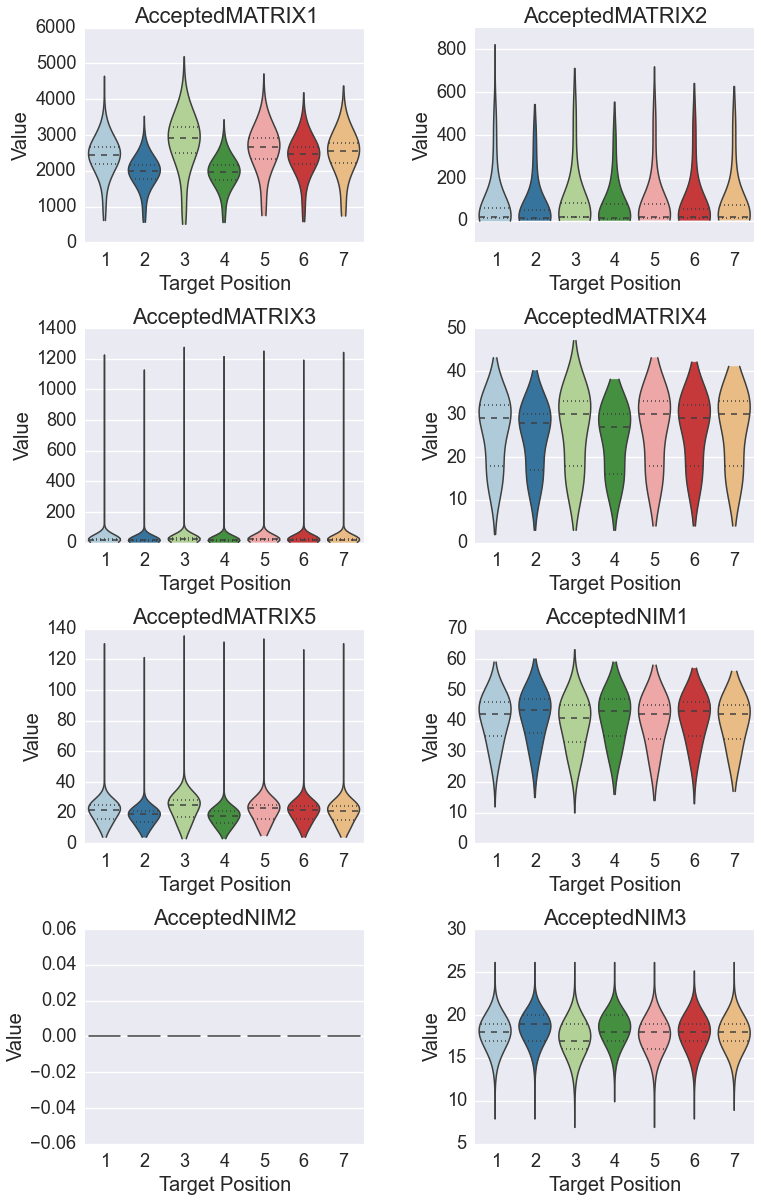

In [23]:
# Take a look at the first eight
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,20))
index = 0
for value_name in value_names[:8]:
    subset_df = data_df[(data_df.name == value_name)]
    axis = axes[floor(index/2),index%2]
    sns.violinplot(subset_df.value,              # We want to inspect the feature
                   subset_df.targetPos,          #   the distributions, and how they
                   color="Paired",               #   differ for each target position.
                   bw=0.7,                       # The side-by-side, normalized nature 
                   ax=axis)                      #   of violin plots are ideal for this.  
    axis.set_title(value_name)
    axis.set_xlabel('Target Position', fontsize=20)
    axis.set_ylabel('Value', fontsize=20)
    index = index + 1
    
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

## Clean the Data some more
### *Feature Exclusion*

1. Pivot the dataframe
2. Eliminate rows with missing data
3. Inspect the means and standard deviations
4. Identify the *zero standard deviation* features, as they're not helpful
5. Remove them from our pivoted dataframe and our scaler_df dataset

In [24]:
# We want to see our scalerNames as column indexes
pivoted_df = data_df.pivot('spillID', 'name', 'value'); pivoted_df.head()

name     AcceptedBOS  AcceptedEOS  AcceptedMATRIX1  AcceptedMATRIX2  \
spillID                                                               
409563             0            1              808               93   
409564             0            1              849               83   
409565             0            1              776               87   
409566             0            1              855               90   
409567             0            1              826               86   

name     AcceptedMATRIX3  AcceptedMATRIX4  AcceptedMATRIX5  AcceptedNIM1  \
spillID                                                                    
409563                 7               11                8            24   
409564                 6               13                8            26   
409565                 7               12                8            23   
409566                 7               12                8            27   
409567                 6               13                9            28   

name     AcceptedNIM2  AcceptedNIM3  AcceptedNIM4  AcceptedNIM5  \
spillID                                                           
409563              0            16             0             0   
409564              0            20             0             0   
409565              0            17             0             0   
409566              0            18             0             0   
409567              0            15             0             0   

name     AfterInhMATRIX1  AfterInhMATRIX2  AfterInhMATRIX3  AfterInhMATRIX4  \
spillID                                                                       
409563               806           105741              864           308482   
409564               847            94634              816           325076   
409565               774            98952              874           313197   
409566               855           102557              876           304233   
409567               824            97749              761           321353   

name     AfterInhMATRIX5  AfterInhNIM1  AfterInhNIM2  E:M2C2HF      
spillID                                                             
409563             20032       1074482       7668937  0.588439 ...  
409564             20812       1125483       8121560  0.533666 ...  
409565             19887       1075133       7872807  0.562404 ...  
409566             19508       1076774       7851474  0.572679 ...  
409567             20088       1109285       8167020  0.573294 ...  

[5 rows x 90 columns]

### Handle missing data

In [26]:
# Replace sentinel values with NaN's and then drop those rows
pivoted_df = pivoted_df.replace(-9999,np.nan).dropna(axis=0,how='any')

In [27]:
# We take a peek to see what the values in each look like overall
pivoted_df.describe()

name,AcceptedBOS,AcceptedEOS,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM2,AcceptedNIM3,AcceptedNIM4,AcceptedNIM5,AfterInhMATRIX1,AfterInhMATRIX2,AfterInhMATRIX3,AfterInhMATRIX4,AfterInhMATRIX5,AfterInhNIM1,AfterInhNIM2,E:M2C2HF,
count,46416,46416,46416.000000,46416.000000,46416.000000,46416.000000,46416.000000,46416.000000,46416,46416.000000,46416,46416,46416.000000,46416.000000,46416.000000,46416.000000,46416.000000,46416.000000,46416.000000,46416.000000,...
mean,0,1,2395.605265,78.802762,22.043843,25.623406,20.374074,40.141955,0,17.790805,0,0,2921.722682,255300.182803,3256.771501,760553.851237,58113.473414,1597429.165051,12363367.193166,1.473766,...
std,0,0,630.960043,127.888964,45.137150,7.746402,7.262025,7.482235,0,1.785314,0,0,981.711313,199107.022268,5599.279285,229066.293383,19782.287330,247344.078433,3015483.568559,0.764595,...
min,0,1,505.000000,1.000000,4.000000,4.000000,5.000000,12.000000,0,9.000000,0,0,503.000000,24268.000000,531.000000,116053.000000,11554.000000,573793.000000,3074828.000000,0.111486,...
25%,0,1,2050.000000,13.000000,17.000000,18.000000,16.000000,35.000000,0,17.000000,0,0,2395.000000,133538.750000,2470.000000,599644.250000,49696.750000,1402212.000000,10131216.500000,0.908831,...
50%,0,1,2449.000000,17.000000,20.000000,29.000000,21.000000,42.000000,0,18.000000,0,0,2910.000000,171214.000000,3027.000000,849329.500000,61836.500000,1693271.000000,13332940.500000,1.405818,...
75%,0,1,2783.000000,67.000000,24.000000,32.000000,25.000000,46.000000,0,19.000000,0,0,3460.000000,264367.250000,3607.000000,925483.500000,69085.500000,1785526.500000,14964360.500000,1.866966,...
max,0,1,5183.000000,818.000000,1272.000000,45.000000,133.000000,61.000000,0,24.000000,0,0,9926.000000,1966838.000000,157050.000000,1333842.000000,308908.000000,2558621.000000,17580954.000000,6.192471,...


### Identify *zero standard deviation* features

In [28]:
# It's sufficient to say that if the standard deviation is 0, then it's certainly not useful
zero_std_series = (pivoted_df.describe().ix['std'] == 0)
# Get an array of all the features with zero standard deviations
zero_std_features = zero_std_series[zero_std_series == True].index.values; zero_std_features

array(['AcceptedBOS', 'AcceptedEOS', 'AcceptedNIM2', 'AcceptedNIM4',
       'AcceptedNIM5', 'E:M3TGHF', 'E:M3TGHI', 'E:M3TGVF', 'E:M3TGVI',
       'F:NM3ION', 'G:BNCH13', 'NM3SEM', 'PrescaleNIM2', 'PrescaleNIM4',
       'PrescaleNIM5', 'PrescaledBOS', 'PrescaledEOS'], dtype=object)

### Remove these from our analysis

In [29]:
# Get rid of these features
_ = pivoted_df.drop(zero_std_features, axis=1, inplace=True)

# Assemble Cleaned, Processed Data
### With data and labels, so that it's well-suited to be fed to our RFC

In [30]:
# Let's prepare the lables, or, our target positions
targpos_df = data_df[['spillID','targetPos']].drop_duplicates().sort('spillID')
targpos_df.head()

,spillID,targetPos
254012,409563,1
254056,409564,1
254100,409565,1
254144,409566,1
254188,409567,1


### Merge the data with the labels

In [31]:
full_df = pd.merge(pivoted_df, targpos_df, how='left', right_on='spillID', left_index=True)

In [32]:
full_df = full_df.set_index('spillID')
full_df.head()

AcceptedMATRIX1  AcceptedMATRIX2  AcceptedMATRIX3  AcceptedMATRIX4  \
spillID                                                                       
409563               808               93                7               11   
409564               849               83                6               13   
409565               776               87                7               12   
409566               855               90                7               12   
409567               826               86                6               13   

         AcceptedMATRIX5  AcceptedNIM1  AcceptedNIM3  AfterInhMATRIX1  \
spillID                                                                 
409563                 8            24            16              806   
409564                 8            26            20              847   
409565                 8            23            17              774   
409566                 8            27            18              855   
409567                 9            28            15              824   

         AfterInhMATRIX2  AfterInhMATRIX3  AfterInhMATRIX4  AfterInhMATRIX5  \
spillID                                                                       
409563            105741              864           308482            20032   
409564             94634              816           325076            20812   
409565             98952              874           313197            19887   
409566            102557              876           304233            19508   
409567             97749              761           321353            20088   

         AfterInhNIM1  AfterInhNIM2  E:M2C2HF  E:M2C2HI  E:M2C2HM   E:M2C2HS  \
spillID                                                                        
409563        1074482       7668937  0.588439     16294 -0.307966  13.707375   
409564        1125483       8121560  0.533666     17009 -0.038069  13.580206   
409565        1075133       7872807  0.562404     16732 -0.220535  13.662904   
409566        1076774       7851474  0.572679     15775 -0.277687  13.679939   
409567        1109285       8167020  0.573294     14999 -0.225248  13.655654   

         E:M2C2VF  E:M2C2VI      
spillID                          
409563   0.596055   15929.0 ...  
409564   0.564570   16418.0 ...  
409565   0.573993   16392.0 ...  
409566   0.598182   15249.0 ...  
409567   0.579170   14720.5 ...  

[5 rows x 74 columns]

## And here is our full data set in all its glory
70 features, no NaN's, and no completely meaningless features (std dev != 0)

In [33]:
# Write it to file for use in the next part.
full_df.to_csv('insight_demo_roadset62.csv')

# Create, Train Random Forest From Data

In [5]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation              # We'll want to cross-validate our RF
sns.set_context("poster")

In [6]:
# If the data is already written, and we're re-visiting, 
#    just load the prepared data here
full_df = pd.read_csv('insight_demo_roadset62.csv', index_col='spillID')

In [7]:
# Split the DataFrame up into 'data' and 'labels'
labels = full_df.values[:,-1]

## Feature Engineering
* One thing we do know in this experiment is that *'S:G2SEM'* is a measure of ***Beam Intensity***
* ***Beam Intensity*** does not depend on anything in our experiment...
* BUT many, *many* things in our experiment depend on *Beam Intensity*
* So, normalize all *features* to ***Beam Intensity*** for more robust classifier

In [8]:
# Rescale the training data to beam intensity
#    Beam intensity is a big number (O(10^12)), so multiply by a big constant
#    to bring it back up to normal feature ranges 
engineered_df = pd.DataFrame( (full_df.drop('targetPos', axis=1).values / full_df[['S:G2SEM']].values) * 5000000000000.0, 
                              columns=full_df.columns[:-1] )

_ = engineered_df.drop('S:G2SEM', axis=1, inplace=True)

## Feature Scaling
* Over time, these features may *drift* a little due to many, many effects
* Hopefully, the relative differences are key to differentiating targets

In [9]:
data = engineered_df.values

In [10]:
scale = StandardScaler().fit(data)

In [11]:
data_scaled = scale.transform(data)

### Split our data up into training and test sets

In [12]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_scaled, labels, test_size=0.33, random_state=2)

### Create RFC instance

In [13]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2)

### Train on training data

In [14]:
rfc.fit(d_train, l_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [15]:
result = rfc.predict(d_test)

print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  90.2%


### Create a Confusion histogram to examine prediction performance

In [79]:
def confusion(labels, results, names):
    plt.figure(figsize=(10, 10))
    
    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(labels.astype(int), results.astype(int), bins=len(names))

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(np.flipud(pts.astype(int)), index=np.flipud(names), columns=names )

    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d", cbar=False)

    _, ylabels = plt.xticks()
    _, xlabels = plt.yticks()
    plt.setp(xlabels, rotation=45)
    plt.setp(ylabels, rotation=45)
    plt.xlabel("Actual", size=22)
    plt.ylabel("Prediction", size=22)
    
    return pts

def per_target_accuracy(hist2d_pts, names):

    for i in range(len(names)):
        rowsum = np.sum(hist2d_pts.T[i])
        if rowsum>0:
            print names[i] + ":   \t" + str(round((hist2d_pts[i][i] / np.sum(hist2d_pts.T[i]))*100,2)) + "%"
        else:
            print names[i] + ":   \tN/A"

Hydrogen:   	93.52%
Empty:   	67.35%
Deuterium:   	97.81%
None:   	71.97%
Carbon:   	97.68%
Iron:   	92.51%
Tungsten:   	88.82%


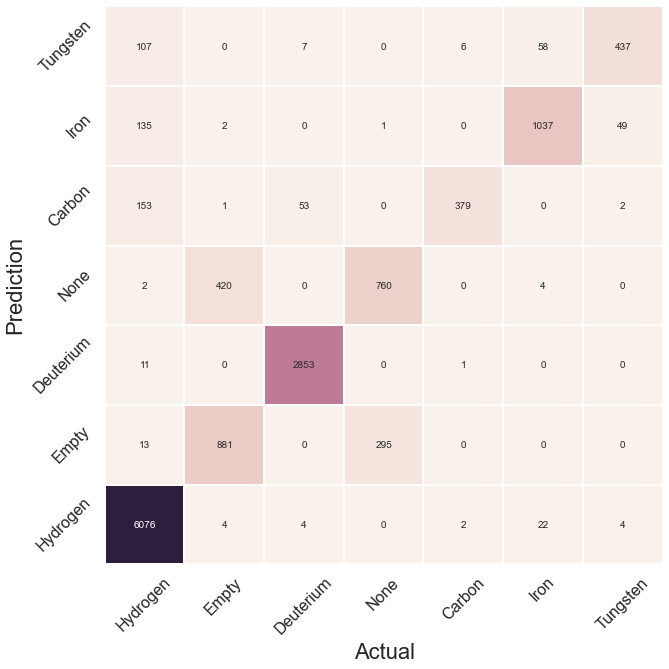

In [80]:
# Define names for the target positions
names = ['Hydrogen','Empty','Deuterium','None','Carbon','Iron','Tungsten']

pts = confusion(l_test, result, names)
per_target_accuracy(pts, names)

### Domain knowledge: "Empty" and "None" Similarity
* *"Empty"* is basically a hollow tin can
* *"None"* is no target at all
* Used to study background signals
* Will be naturally very, very similar -- and we see above that they get mistaken for each other
* We can collapse these into one category

In [81]:
def relabel(label_array):
    # Collapse target position 4 and 2 both into category 2
    # Then shift over the rest
    label_array_revised = label_array.copy()
    label_array_revised[label_array_revised == 4] = 2
    label_array_revised[label_array_revised == 5] = 4
    label_array_revised[label_array_revised == 6] = 5
    label_array_revised[label_array_revised == 7] = 6
    
    return label_array_revised

In [82]:
# Call the new re-labelling function
#    and modify the names array
labels_revised = relabel(labels)
names = ['Hydrogen','Empty/None','Deuterium','Carbon','Iron','Tungsten']

In [83]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_scaled, labels_revised, test_size=0.33, random_state=5)

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)

result = rfc.predict(d_test)
print("RF prediction accuracy = {0:5.1f}%\n".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  95.4%



Hydrogen:   	93.43%
Empty/None:   	99.46%
Deuterium:   	98.07%
Carbon:   	96.17%
Iron:   	93.6%
Tungsten:   	87.91%


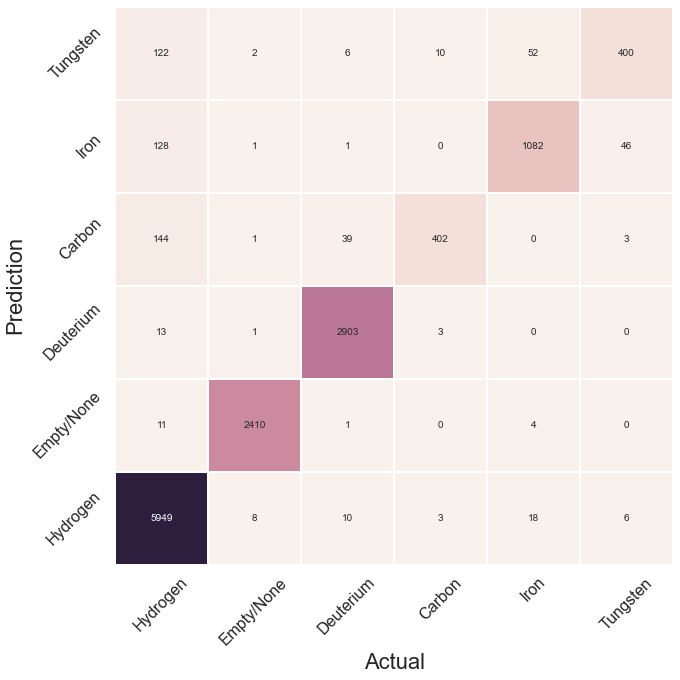

In [84]:
pts = confusion(l_test, result, names)   # Show confusion matrix
per_target_accuracy(pts, names)          # Print per-target accuracy

# Most Valuable Features
* Rank our top most valuable features
* See if any make obvious sense
* Perhaps use only useful features in future iterations

In [87]:
features = full_df.drop(['S:G2SEM','targetPos'], axis=1).columns.values
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

useful_feature_list = []
for f in range(20):
    print("%d. Feature '%s' (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    useful_feature_list.append(features[indices[f]])

Feature ranking:
1. Feature 'G:RD3161' (0.102309)
2. Feature 'AfterInhMATRIX5' (0.088476)
3. Feature 'G:RD3162' (0.069903)
4. Feature 'PrescaleMATRIX5' (0.069320)
5. Feature 'RawMATRIX4' (0.053608)
6. Feature 'RawTriggers' (0.050139)
7. Feature 'RawMATRIX5' (0.043737)
8. Feature 'PrescaleMATRIX3' (0.029260)
9. Feature 'PrescaledTrigger' (0.026003)
10. Feature 'TSGo' (0.024862)
11. Feature 'TsBusy' (0.024835)
12. Feature 'AfterInhMATRIX3' (0.024577)
13. Feature 'AfterInhMATRIX4' (0.022194)
14. Feature 'RawMATRIX2' (0.019794)
15. Feature 'PrescaleMATRIX2' (0.019617)
16. Feature 'AcceptedMATRIX1' (0.019156)
17. Feature 'AfterInhMATRIX2' (0.018145)
18. Feature 'PrescaleMATRIX1' (0.017360)
19. Feature 'PrescaleMATRIX4' (0.016189)
20. Feature 'AfterInhMATRIX1' (0.015923)


## Train on *useful*, vetted, approved features
* Time-invariant (always been read out, always will be read out)for the experiment
* Ensures that our RFC can be used on past and future data

In [89]:
reduced_df = pd.DataFrame( (full_df[useful_feature_list].values / full_df[['S:G2SEM']].values) * 5000000000000.0, 
                              columns=useful_feature_list )
data_reduced = reduced_df.values
scale_reduced = StandardScaler().fit(data_reduced)
data_reduced_scaled = scale_reduced.transform(data_reduced)

RF prediction accuracy =  95.4%
Hydrogen:   	93.99%
Empty/None:   	99.37%
Deuterium:   	98.12%
Carbon:   	92.58%
Iron:   	93.69%
Tungsten:   	86.7%


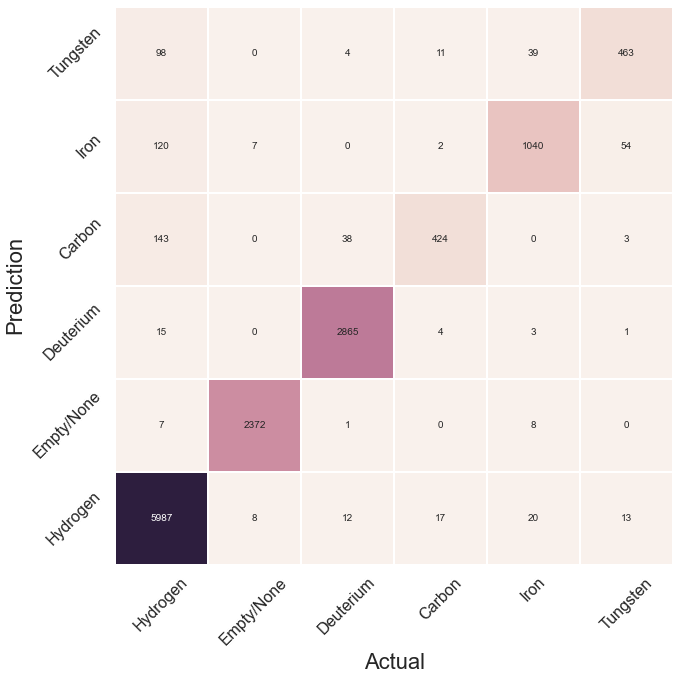

In [90]:
# We've reduced the number of features and normalized them all to beam intensity
# Let's see how that's affected our predictor

d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_reduced_scaled, labels_revised, test_size=0.33, random_state=6)
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)
result = rfc.predict(d_test)
print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc_reduced.score(d_test, l_test)))

pts = confusion(l_test, result, names)
per_target_accuracy(pts, names)

# Cross-Validation
* Let us exhaustively check how robust the RFC is
* We do this by cross-validation using the whole data set
* Randomly split the data into 10 *folds* using KFold

In [91]:
kf_total = cross_validation.StratifiedKFold(labels_revised, n_folds=10, shuffle=True, random_state=4)
rfc_scores = cross_validation.cross_val_score(rfc, data_reduced_scaled, labels_revised, cv=kf_total)

In [92]:
print "RFC Scores: ", rfc_scores
print "Accuracy: %0.2f (+/- %0.2f)" % (rfc_scores.mean(), rfc_scores.std() * 2)

RFC Scores:  [ 0.951  0.958  0.96   0.96   0.957  0.964  0.963  0.963  0.96   0.967]
Accuracy: 0.96 (+/- 0.01)


# Can we do better with K-Neighbor or SVM?

In [ ]:
from sklearn import neighbors
from sklearn import svm
from sklearn import preprocessing

In [ ]:
C = 1.0  # SVM regularization parameter
k_neighbors = 15

svc = svm.SVC(kernel='linear', C=C).fit(d_train, l_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(d_train, l_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(d_train, l_train)
lin_svc = svm.LinearSVC(C=C).fit(d_train, l_train)
knclf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights).fit(d_train, l_train)
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)

In [ ]:
svc_result =      svc.predict(d_test)
rbf_svc_result =  rbf_svc.predict(d_test)
poly_svc_result = poly_svc.predict(d_test)
lin_svc_result =  lin_svc.predict(d_test)
knclf_result =    knclf.predict(d_test)
rfc_result =      rfc.predict(d_test)

In [ ]:
print("SVC prediction accuracy = {0:5.1f}%".format(100.0 * svc.score(d_test, l_test)))
print("RBF SVC prediction accuracy = {0:5.1f}%".format(100.0 * rbf_svc.score(d_test, l_test)))
print("Polynomial SVC prediction accuracy = {0:5.1f}%".format(100.0 * poly_svc.score(d_test, l_test)))
print("Linear SVC prediction accuracy = {0:5.1f}%".format(100.0 * lin_svc.score(d_test, l_test)))
print("K-Neighbor prediction accuracy = {0:5.1f}%".format(100.0 * knclf.score(d_test, l_test)))
print("RFC prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

# Pickle our trained RFC for use in the field

In [337]:
from sklearn.externals import joblib

In [31]:
# Train using our full data set
rfc_final = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None,
                             min_samples_split=1, random_state=2).fit(data_reduced_scaled, labels_revised)

In [39]:
data_reduced[:5]

array([[  5.892e+00,   3.189e+04,   1.023e+01,   1.344e+01,   1.992e+03,
          1.550e+01,   1.903e+03,   2.274e+06,   1.907e+03,   2.215e+03,
          1.115e+07,   2.228e+03,   2.214e+03,   4.057e+05,   1.907e+03,
          1.596e+06,   1.126e+07,   3.017e+05],
       [  5.108e+00,   2.874e+04,   9.287e+00,   1.238e+01,   1.879e+03,
          1.548e+01,   1.843e+03,   1.944e+06,   1.845e+03,   2.182e+03,
          9.870e+06,   2.199e+03,   2.181e+03,   3.350e+05,   1.845e+03,
          1.665e+06,   1.024e+07,   3.471e+05],
       [  6.267e+00,   2.591e+04,   1.077e+01,   1.071e+01,   1.483e+03,
          1.286e+01,   1.385e+03,   2.190e+06,   1.385e+03,   1.671e+03,
          9.214e+06,   1.684e+03,   1.670e+03,   3.685e+05,   1.386e+03,
          1.578e+06,   1.031e+07,   2.885e+05],
       [  6.472e+00,   2.698e+04,   1.079e+01,   1.130e+01,   1.500e+03,
          1.233e+01,   1.419e+03,   2.189e+06,   1.420e+03,   1.700e+03,
          9.810e+06,   1.706e+03,   1.699e+03,   3.93

In [13]:
test_df = pd.read_csv('testrun.csv', index_col='spillID')

In [16]:
test_labels = test_df.values[:,-1]
test_labels = relabel(test_labels)

array([ 3.,  3.,  2.,  4.,  5.,  6.,  5.,  2.,  3.,  3.,  2.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  3.,  3.,  3.,  2.,
        4.,  5.,  6.,  5.,  2.,  3.,  3.,  2.,  1.,  1.,  1.])

In [30]:
test_data = test_df[useful_feature_list]

RF prediction accuracy =  27.0%
Hydrogen:   	14.29%
Empty/None:   	38.89%
Deuterium:   	N/A
Carbon:   	N/A
Iron:   	N/A
Tungsten:   	16.67%


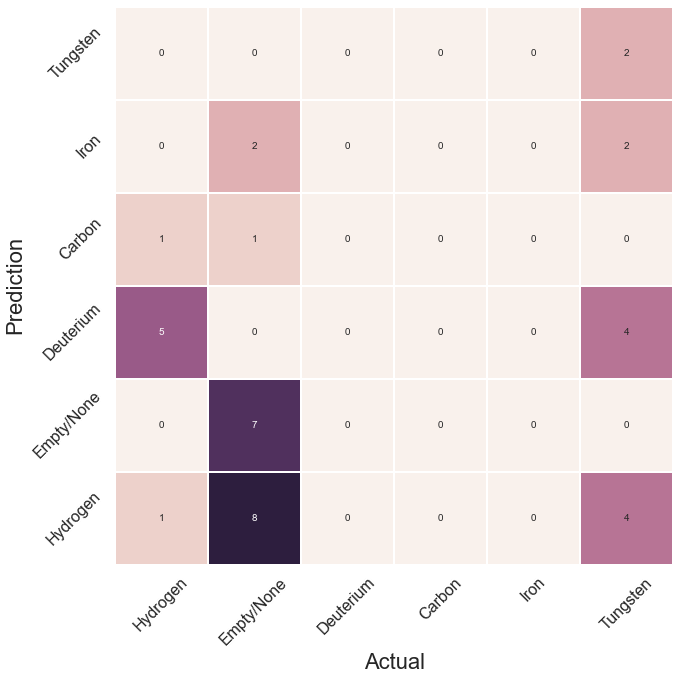

In [32]:
result = rfc_final.predict(test_data)
print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc_final.score(test_data, test_labels)))

pts = confusion(test_labels, result, names)
per_target_accuracy(pts, names)

In [35]:
from sklearn.metrics import confusion_matrix

In [38]:
print test_labels
print result

[ 3.  3.  2.  4.  5.  6.  5.  2.  3.  3.  2.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  2.  3.  3.  3.  2.  4.  5.  6.  5.  2.  3.  3.  2.  1.  1.
  1.]
[ 5.  5.  2.  2.  2.  5.  2.  2.  1.  5.  2.  2.  1.  5.  5.  2.  2.  5.
  2.  2.  2.  2.  1.  1.  5.  2.  1.  5.  5.  5.  2.  1.  1.  2.  5.  2.
  2.]


In [36]:
confusion_matrix(test_labels, result)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2499: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


array([[1, 8, 0, 0, 4, 0],
       [0, 7, 0, 0, 0, 0],
       [5, 0, 0, 0, 4, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 2, 0],
       [0, 0, 0, 0, 2, 0]])

In [356]:
# Write our pickled classifier to file`
rfc_pickle_name = "models/target_rfc_roadset62.pkl"

if os.path.exists(rfc_pickle_name):
    os.remove(rfc_pickle_name)

joblib.dump(rfc_final, rfc_pickle_name)

['models/target_rfc_roadset62.pkl',
 'models/target_rfc_roadset62.pkl_01.npy',
 'models/target_rfc_roadset62.pkl_02.npy',
 'models/target_rfc_roadset62.pkl_03.npy',
 'models/target_rfc_roadset62.pkl_04.npy',
 'models/target_rfc_roadset62.pkl_05.npy',
 'models/target_rfc_roadset62.pkl_06.npy',
 'models/target_rfc_roadset62.pkl_07.npy',
 'models/target_rfc_roadset62.pkl_08.npy',
 'models/target_rfc_roadset62.pkl_09.npy',
 'models/target_rfc_roadset62.pkl_10.npy',
 'models/target_rfc_roadset62.pkl_11.npy',
 'models/target_rfc_roadset62.pkl_12.npy',
 'models/target_rfc_roadset62.pkl_13.npy',
 'models/target_rfc_roadset62.pkl_14.npy',
 'models/target_rfc_roadset62.pkl_15.npy',
 'models/target_rfc_roadset62.pkl_16.npy',
 'models/target_rfc_roadset62.pkl_17.npy',
 'models/target_rfc_roadset62.pkl_18.npy',
 'models/target_rfc_roadset62.pkl_19.npy',
 'models/target_rfc_roadset62.pkl_20.npy',
 'models/target_rfc_roadset62.pkl_21.npy',
 'models/target_rfc_roadset62.pkl_22.npy',
 'models/target_rf

In [344]:
data_reduced.shape
reduced_df.columns

Index([u'G:RD3161', u'AfterInhMATRIX5', u'G:RD3162', u'PrescaleMATRIX5', u'AfterInhMATRIX3', u'PrescaleMATRIX3', u'AcceptedMATRIX1', u'RawNIM1', u'AfterInhMATRIX1', u'TsBusy', u'AfterInhNIM2', u'PrescaledTrigger', u'TSGo', u'AfterInhMATRIX4', u'PrescaleMATRIX1', u'RawMATRIX4', u'RawTriggers', u'RawMATRIX5'], dtype='object')

In [345]:
useful_feature_list

['G:RD3161',
 'AfterInhMATRIX5',
 'G:RD3162',
 'PrescaleMATRIX5',
 'AfterInhMATRIX3',
 'PrescaleMATRIX3',
 'AcceptedMATRIX1',
 'RawNIM1',
 'AfterInhMATRIX1',
 'TsBusy',
 'AfterInhNIM2',
 'PrescaledTrigger',
 'TSGo',
 'AfterInhMATRIX4',
 'PrescaleMATRIX1',
 'RawMATRIX4',
 'RawTriggers',
 'RawMATRIX5']